Porto Seguro's Safe Driver Prediction
====

## Introduction
[This competition](https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/data) is hosted by the third largest insurance company in Brazil: Porto Seguro with the task of predicting the probability that a driver will initiate an insurance claim in the next year.

In the train data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix bin to indicate binary features and cat to indicate categorical features. Features without these designations are either continuous or ordinal. **Values of -1 indicate that the feature was missing** from the observation. The target columns signifies whether or not a claim was filed for that policy holder

train.csv contains the training data, where each row corresponds to a policy holder, and the target columns signifies that a claim was filed.


In [1]:
# Import libraries
# Your code here
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Read csv file and take a look at it
train =pd.read_csv('train.csv')

In [5]:
# Taking a look at how many rows and columns the train dataset contains
rows = train.shape[0] # Your code here
columns = train.shape[1] # Your code here
print("The train dataset contains {} rows and {} columns".format(rows, columns))

The train dataset contains 595212 rows and 59 columns


## 1. Data Quality Checks

### Null or missing values check
Let check whether there are any null values in the train dataset as follows:

In [6]:
# Your code here
train.isnull().values.any()

False

**Note:** Our null values check returns False but however, this does not really mean that this case has been closed as the data is also described as *"Values of -1 indicate that the feature was missing from the observation"*. Therefore I take it that Porto Seguro has simply conducted a blanket replacement of all null values in the data with the value of -1. Let us now inspect if there where any missing values in the data.

Here we can see that which columns contained -1 in their values so we could easily for example make a blanket replacement of all -1 with nulls first as follows:

In [7]:
train_copy = train.copy()
train_copy = train_copy.replace(-1, np.NaN)

We can use "Missingno" to visualize missing values in the dataset.

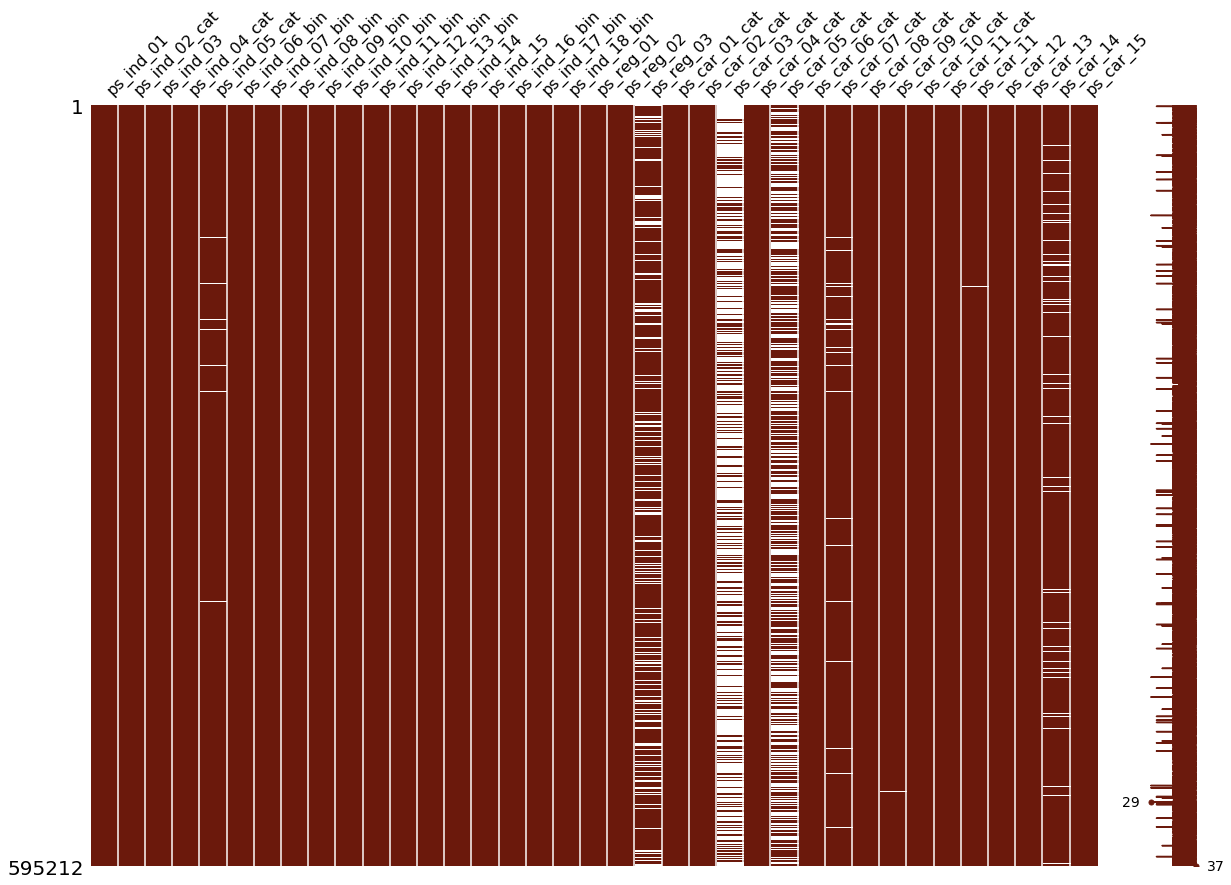

In [9]:
# If you don't have "Missingno" package, use this command to install
# (Linux) conda install -c conda-forge missingno

import missingno as msno

msno.matrix(df=train_copy.iloc[:, 2:39], figsize=(20, 14), color=(0.42, 0.1, 0.05))

In [48]:
# List null columns name
# Hint: isnull()
# Your code here
listNullColumn=train[train==-1].count()
listNullColumn[listNullColumn>0].sort_values()

ps_car_12             1
ps_car_02_cat         5
ps_car_11             5
ps_ind_04_cat        83
ps_car_01_cat       107
ps_ind_02_cat       216
ps_car_09_cat       569
ps_ind_05_cat      5809
ps_car_07_cat     11489
ps_car_14         42620
ps_reg_03        107772
ps_car_05_cat    266551
ps_car_03_cat    411231
dtype: int64

#### Target variable inspection

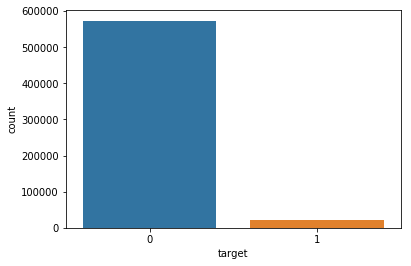

In [124]:
# Using countplot to represent target
# Your code here
sns.countplot(train['target'])

## 2. Feature inspection and filtering

### Correlation plots
As a starter, let us generate some linear correlation plots just to have a quick look at how a feature is linearly correlated to the next and perhaps start gaining some insights from here. At this juncture, I will use the seaborn statistical visualisation package to plot a heatmap of the correlation values. Conveniently, Pandas dataframes come with the corr() method inbuilt, which calculates the Pearson correlation. Also as convenient is Seaborn's way of invoking a correlation plot. Just literally the word "heatmap"

#### Correlation of float features

In [125]:
train_float = train.select_dtypes(include=['float64'])
train_int = train.select_dtypes(include=['int64'])

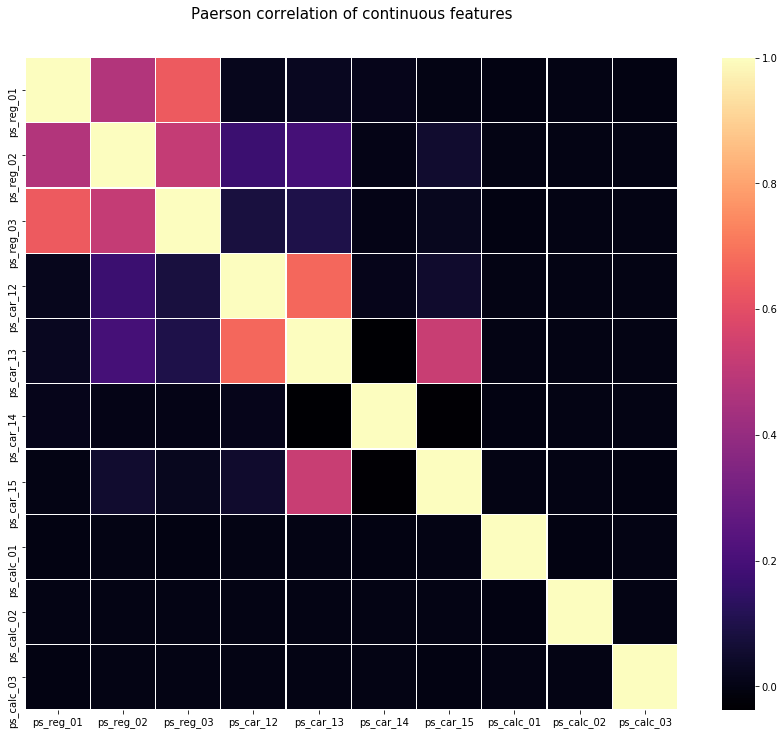

In [126]:
colormap = plt.cm.magma
plt.figure(figsize=(16, 12))
plt.title("Paerson correlation of continuous features", y=1.05, size=15)
sns.heatmap(train_float.corr(), linewidths=0.1, vmax=1.0, square=True,
           cmap=colormap)
plt.show()

From the correlation plot, we can see that the majority of the features display zero or no correlation to one another. This is quite an interesting observation that will warrant our further investigation later down. For now, the paired features that display a positive linear correlation are listed as follows:

(ps_reg_01, ps_reg_03)

(ps_reg_02, ps_reg_03)

(ps_car_12, ps_car_13)

(ps_car_13, ps_car_15)

### Correlation of integer features

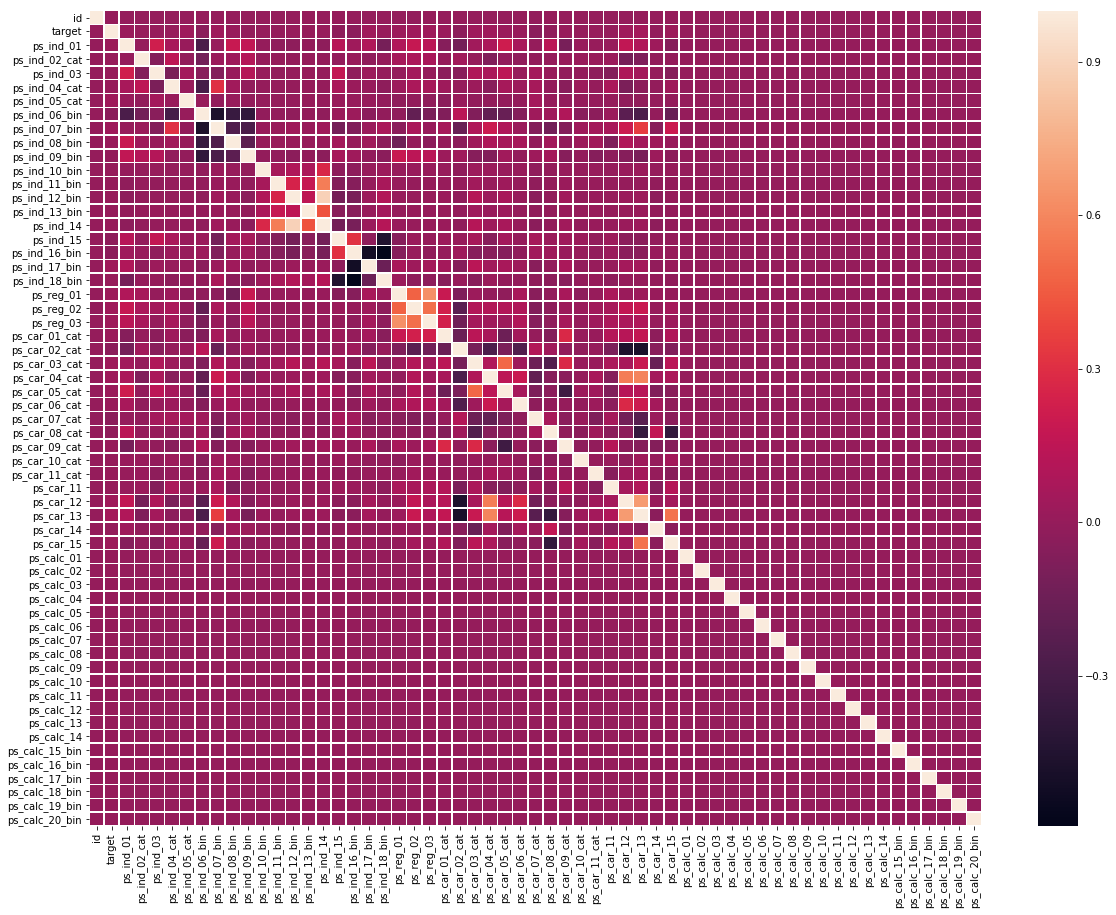

In [134]:
# Your code here
# Hint: correlation of train_int
plt.figure(figsize=(20,15))
sns.heatmap(train.corr(), linewidths=.5)
plt.show()

#### Which features have negatively correlation?
Negatively correlated features : **Your answer here**

### Binary features inspection
Another aspect of the data that we may want to inspect would be the coulmns that only contain binary valeus, i.e where values take on only either of the two values 1 or 0. Proceeding, we store all columns that contain these binary values and then generate a vertical plotly bar plot of these binary values as follows:

In [135]:
bin_col = list(filter(lambda x: '_bin' in x, train.columns))
bin_value_counts = train[bin_col].apply(pd.value_counts)

In [136]:
bin_value_counts

,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,360852,442223,497644,484917,594990,594205,589594,594648,201882,523143,503879,522342,221514,265356,424278,387469,503955
1,234360,152989,97568,110295,222,1007,5618,564,393330,72069,91333,72870,373698,329856,170934,207743,91257


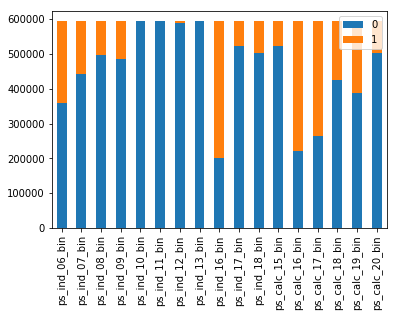

In [142]:
# hint pandas plot.bar with stacked=True
# Your code here
bin_value_counts.T.plot.bar(stacked=True)

Those columns ps_ind_10_bin, ps_ind_11_bin, ps_ind_12_bin, ps_ind_13_bin which are completely dominated by zeros. They do not contain much information.

## 3. Preprocess Data

In [145]:
# Import train_test_split 
# Your code here
from sklearn.model_selection import train_test_split

In [147]:
# Define X (features), y (target)
X = train.drop(columns=['id','target'])
y = train['target']# Your code here

In [148]:
# Split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

#### Randomly Under-Sampling the Training Dataset¶
**Note:** Validate ratio between 2 class after Under-Sampling

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in resampled data:  7288


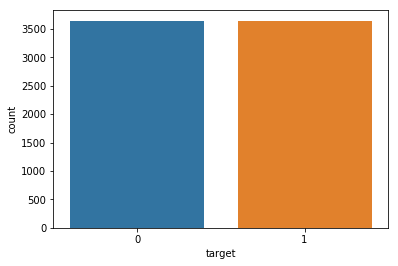

In [157]:
# Your code here
percentage_fraud = (train['target'] == 1).sum() / train.shape[0] * 100
percentage_no_fraud = (train['target'] == 0).sum() / train.shape[0] * 100
number_of_instances = 100000
number_sub_fraud = int (percentage_fraud/100 * number_of_instances)
number_sub_non_fraud = int (percentage_no_fraud/100 * number_of_instances)

training_data = pd.concat([X_train,y_train],axis = 1)
sub_fraud_data = training_data[training_data['target'] == 1].head(number_sub_fraud)
sub_non_fraud_data = training_data[training_data['target'] == 0].head(number_sub_non_fraud)
sub_training_data = pd.concat ([sub_fraud_data, sub_non_fraud_data], axis = 0)
fraud_data = sub_training_data[sub_training_data['target'] == 1]
non_fraud_data = sub_training_data[sub_training_data['target'] == 0]

number_records_fraud = fraud_data.shape[0]
number_records_non_fraud = non_fraud_data.shape[0]

under_sample_non_fraud = non_fraud_data.sample(number_records_fraud)
under_sample_data = pd.concat([under_sample_non_fraud, fraud_data], axis=0)
print("Percentage of normal transactions: ", under_sample_non_fraud.shape[0] / under_sample_data.shape[0])
print("Percentage of fraud transactions: ", fraud_data.shape[0] / under_sample_data.shape[0])
print("Total number of transactions in resampled data: ", under_sample_data.shape[0])


X_train_undersample = under_sample_data.drop(columns=['target'])
y_train_undersample = under_sample_data['target']

sns.countplot(data=under_sample_data, x='target')
plt.show()

#### Randomly Over-Sampling the Training Dataset
**Note:** Validate ratio between 2 class after Over-Sampling

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.018909241866016294
Total number of transactions in resampled data:  192710


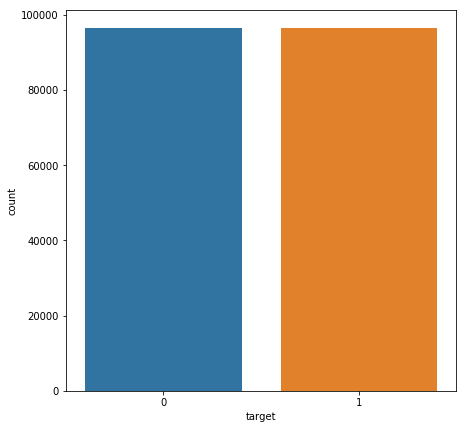

In [159]:
# Your code here
# Fraud/non-fraud data
# Select row which "Class" is 1 and save in fraud_data
fraud_data = sub_training_data[sub_training_data['target'] == 1]
# Select row which "Class" is 0 and save in non_fraud_data
non_fraud_data = sub_training_data[sub_training_data['target'] == 0]

# Number of fraud, non-fraud transactions
number_records_fraud = fraud_data.shape[0]
number_records_non_fraud = non_fraud_data.shape[0]

# Using sample on fraud_data with replacement "replace = True",  since we take a larger sample than population
over_sample_fraud = fraud_data.sample(replace = True, n=number_records_non_fraud)
# **concat** over_sample_fraud and non_fraud_data to form under_sample_data
over_sample_data = pd.concat([over_sample_fraud, non_fraud_data], axis=0)

# Showing ratio
print("Percentage of normal transactions: ", non_fraud_data.shape[0]/over_sample_data.shape[0])
print("Percentage of fraud transactions: ", fraud_data.shape[0]/over_sample_data.shape[0])
print("Total number of transactions in resampled data: ", over_sample_data.shape[0])

# Assigning X, y for over-sampled dataset
X_train_oversample = over_sample_data.drop(columns=['target'])
y_train_oversample = over_sample_data['target']

# Plot countplot
plt.figure(figsize=(7,7))
# Make a count plot to show ratio between 2 class on "Class" column
sns.countplot(data=over_sample_data, x='target')
plt.show()

## 4. Modeling

In [160]:
# Spot check with LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, BernoulliNB, GaussianNB
# Import libraries and and create model
# Your code here
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB


lr = LogisticRegression()
dtc = DecisionTreeClassifier()
rfc = RandomForestClassifier()
bnb = BernoulliNB()
gnb = GaussianNB()
svm = LinearSVC()

models = [lr, dtc, rfc, gnb, bnb]
models_name = ["Logistic Regression", "Decision Tree", "Random Forest", "Bernoulli NB", "Gaussian NB"]

## 5. Evaluation Metrics

In [168]:
# Import confusion_matrix, classification_report
# Your code here
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_score

# We create an utils function, that take a trained model as argument and print out confusion matrix
# classification report base on X and y
def evaluate_model(estimator, X, y,description):
    # Your code here
    prediction = estimator.predict(X)
    np.set_printoptions(precision=2)
    model_name = type(estimator).__name__
    return {'name': model_name, 
            'recall': recall_score(y, prediction),
            'precision': precision_score(y, prediction),
           'description': description}

### Evaluate with Origin dataset

In [169]:
X_train_sub = sub_training_data.drop(columns='target')
y_train_sub = sub_training_data['target']
scores_origin = []
for idx, model in enumerate(models):
    print("Model: {}".format(models_name[idx]))
    # Your code here
    model.fit(X_train_sub, y_train_sub)
    scores_origin.append(evaluate_model(model, X_test, y_test, 'origin'))
    
    print("=======================================")

Model: Logistic Regression
Model: Decision Tree
Model: Random Forest
Model: Bernoulli NB
Model: Gaussian NB


### Evaluate with *Undersampled* dataset

In [170]:
scores_under = []
for idx, model in enumerate(models):
    print("Model: {}".format(models_name[idx]))
    # Your code here
    # Fit your model with Undersampled dataset
    model.fit(X_train_undersample, y_train_undersample)
    scores_under.append(evaluate_model(model, X_test, y_test, 'under'))
    # Evaluate model with X_test, y_test
    print("=======================================")

Model: Logistic Regression
Model: Decision Tree
Model: Random Forest
Model: Bernoulli NB
Model: Gaussian NB


### Evaluate with *Oversampled* dataset

In [171]:
scores_over = []
for idx, model in enumerate(models):
    print("Model: {}".format(models_name[idx]))
    # Your code here
    # Fit your model with Oversampled dataset
    model.fit(X_train_oversample, y_train_oversample)
    scores_over.append(evaluate_model(model, X_test, y_test, 'oversample'))
    # Evaluate model with X_test, y_test
    print("=======================================")

Model: Logistic Regression
Model: Decision Tree
Model: Random Forest
Model: Bernoulli NB
Model: Gaussian NB


### Conclusion

Which model has lowest/highest accuracy?
Which model has lowest/highest recall?
Which model has lowest/highest f1?

## 6. GridsearchCV

In [ ]:
# Using gridsearchcv, random forest model and this param grid to find the best combination of parameters 
# Hint: example
# https://stackoverflow.com/questions/30102973/how-to-get-best-estimator-on-gridsearchcv-random-forest-classifier-scikit

param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}



#### which is the best combination of parameter

In [ ]:
# Your code here

# Done! Great Job.